<a href="https://colab.research.google.com/github/yannidd/analog-electronics-nn/blob/master/python/plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
# !pip install --upgrade plotly
!pip install ltspice

In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import plotly.graph_objects as go
import base64
import ltspice
import logging
import urllib

from IPython.display import HTML
from matplotlib import animation
from mpl_toolkits.mplot3d import axes3d
from tempfile import NamedTemporaryFile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD

##### Define XOR data

In [0]:
x = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
y = np.array([-1, 1, 1, -1])

##### Plot XOR data


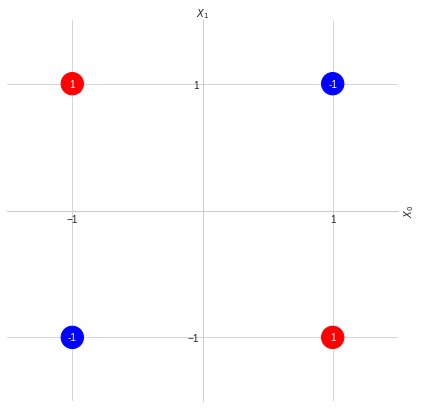

In [4]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', s=500)
ax.set_ylim(-1.5, 1.5)
ax.set_xlim(-1.5, 1.5)
plt.yticks([-1, 1])
plt.xticks([-1, 1])
ax.set_ylabel(f'$X_0$')
ax.set_xlabel(f'$X_1$')
ax.xaxis.set_label_position('top')
ax.yaxis.set_label_position('right')

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i, txt in enumerate(y):
  ax.annotate(txt, (x[i, 0], x[i, 1]), ha='center', va='center', color='w')

##### Load simulation data


In [0]:
# Download simulation data from Github.
url = 'https://github.com/yannidd/analog-electronics-nn/blob/master/ltspice/networks/xor/xor.raw?raw=true'
urllib.request.urlretrieve(url, 'xor.raw')

# Parse simulation data.
filepath = 'xor.raw'
l = ltspice.Ltspice(filepath)
l.parse()

# Extract simulation data and split into simulation cases.
y_sim = l.getData('V(y)')
y_sim = np.array(np.split(y_sim, 31))  # From -1.5 to 1.5 with a 0.1 step, 
                                       # therefore 31 cases.

##### Create TF model and add weights


In [0]:
def accuracy(y_true, y_pred):
  return K.abs(y_true - y_pred) < 0.1

model = Sequential()

model.add(Dense(2, activation='tanh', input_shape=(2,)))
model.add(Dense(1, activation='tanh'))

model.compile(optimizer=SGD(lr=0.1),
              loss='mse',
              metrics=[accuracy])

model.layers[0].set_weights(
    [np.array([[-1.4473087, -1.6303953], [-1.4470474, -1.6299497]]), 
     np.array([-1.2659273, 1.474662 ])])
model.layers[1].set_weights(
    [np.array([[-2.3368418], [ 2.3172097]]), 
     np.array([-2.0349612])])

a = b = np.arange(-1.5, 1.6, 0.1)  # End is 1.6 so that range will stop at 
                                   # 1.6 - step = 1.5
A, B = np.meshgrid(a, b)
Q = np.array(np.split(model.predict(np.array(list(zip(A.flatten(), B.flatten())))).flatten(), len(a)))

##### Plot the outputs from the mathematical and electronic models


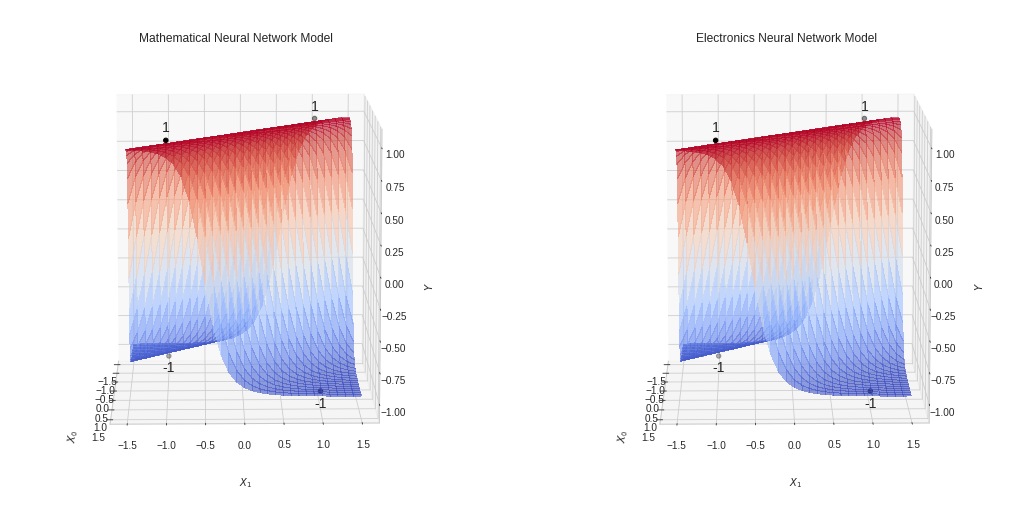

In [42]:
fig = plt.figure(figsize=(14, 7))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
plt.tight_layout()

axs = []
axs.append(fig.add_subplot(1, 2, 1, projection='3d'))
axs.append(fig.add_subplot(1, 2, 2, projection='3d'))
# axs.append(fig.add_subplot(1, 3, 3))

surf = axs[0].plot_surface(A, B, Q, cmap='coolwarm',
                          linewidth=0, antialiased=False, alpha=0.6)
axs[0].set_title('Mathematical Neural Network Model')

surf = axs[1].plot_surface(A, B, y_sim, cmap='coolwarm',
                          linewidth=0, antialiased=False, alpha=0.6)
axs[1].set_title('Electronics Neural Network Model')

for i in range(2):
  # Set labels.
  axs[i].set_xlabel(f'$ X_0 $', labelpad=20)
  axs[i].set_ylabel(f'$ X_1 $', labelpad=20)
  axs[i].set_zlabel(f'$ Y $', labelpad=20)

  # Add true data points.
  axs[i].scatter(x[:, 0], x[:, 1], y, c='k')
  for j, txt in enumerate(y):
    axs[i].text(x[j, 0], x[j, 1], y[j] * 1.1, txt, size=14, ha='center', va='center')


def init():
  return fig,

def animate(angle):
  axs[0].view_init(elev=10., azim=angle)
  axs[1].view_init(elev=10., azim=angle)
  return fig,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=100, blit=True, )

# Save and output the animation.
anim.save('networks_outputs.mp4', extra_args=['-vcodec', 'h264'])
HTML(anim.to_html5_video())

In [0]:
anim.save('networks_outputs.mp4', extra_args=['-vcodec', 'h264'])

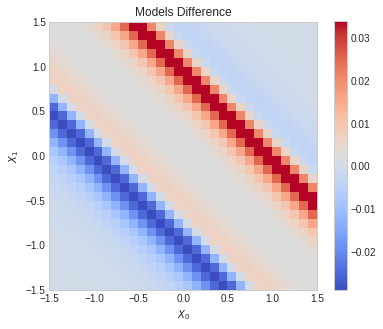

In [41]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
im = ax.pcolormesh(A, B, Q - y_sim, cmap='coolwarm')
ax.set_xlabel(f'$ X_0 $', labelpad=5)
ax.set_ylabel(f'$ X_1 $', labelpad=5)
ax.set_title('Models Difference')
ax.set_aspect('equal')
fig.colorbar(im, ax=ax, shrink=0.825)